In [ ]:
# allow the notebook to access the parent directory so we can import the other modules
# https://stackoverflow.com/a/35273613
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Data Preparation
-----

### Constants and Folder Paths

In [136]:
dataset_folder_path = os.path.join("files", "dataset")
NUM_SAMPLES = 50

### Load Data and Split into *Test*, *Train/Valid*

In [145]:
from data.DataSet import DataSet
dataset = DataSet()
dataset.load(dataset_folder_path, test_set_percentage=0.5)

In [146]:
print(len(dataset.train_data))
print(len(dataset.test_data))

1800
1800


### Data Preprocessing

In [147]:
from utils.preprocessing import *
from functools import partial
dataset.apply(apply_mean_centering)
dataset.apply(apply_unit_distance_normalization)
#dataset.apply(partial(normalize_pressure_value, max_pressure_val=512))
dataset.apply(partial(spline_interpolate_and_resample, num_samples=NUM_SAMPLES))
dataset.expand(reverse_digit_sequence)
# dataset.apply(lambda digit: convert_xy_to_derivative(digit, normalize=False))
#dataset.apply(partial(convert_xy_to_derivative, normalize=True))

In [148]:
print(len(dataset.train_data))
print(len(dataset.test_data))

3600
3600


### Split Dataset into *Train*, *Valid*, and *Test*

In [149]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train_valid = np.array(dataset.train_data)
X_test = np.array(dataset.test_data)
# Convert labels to numpy array and OneHot encode them
encoder, train_valid_labels, Y_test = dataset.get_labels_as_numpy(onehot=True)
train_valid_labels = train_valid_labels.astype('float32').todense()
Y_test = Y_test.astype('float32').todense()
# Split Data
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_valid, train_valid_labels, shuffle=True, stratify=train_valid_labels, random_state=42)

----------
# Neural Network Setup and Training
----------

## **Regularized Naive GRU**

### Parameters

In [150]:
PARAM_NUM_EPOCHS = 30
PARAM_BATCH_SIZE = 300

### Setup Model

In [151]:
from models.regularized_gru import NaiveRegularizedGRU

mymodel = NaiveRegularizedGRU(X_train.shape[1:])
mymodel.batch_size = PARAM_BATCH_SIZE
mymodel.num_epochs = PARAM_NUM_EPOCHS
mymodel.initialize()
print(mymodel)



----------

Optimizer: <class 'keras.optimizers.Nadam'>
Batch Size: 300
Number of Epochs: 30

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_15 (GRU)                 (None, 50, 256)           198912    
_________________________________________________________________
dropout_15 (Dropout)         (None, 50, 256)           0         
_________________________________________________________________
gru_16 (GRU)                 (None, 256)               393984    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_8 (Activation)    (None, 10)                0         
Total params: 595,466
Trainable params: 595,46

#### Save Model Summary

In [152]:
mymodel.save_summary(dataset.get_recorded_operations())
mymodel.save_config()

### Train Model

In [153]:
mymodel.train(X_train, Y_train, X_valid, Y_valid)

Train on 2700 samples, validate on 900 samples
Epoch 1/30
2700/2700 [==============================] - 1s 494us/step - loss: 2.1803 - categorical_accuracy: 0.1863 - val_loss: 2.1012 - val_categorical_accuracy: 0.1911

Epoch 00001: val_categorical_accuracy improved from -inf to 0.19111, saving model to checkpoints/1524406933.4725032/naive_regularized_gru-01-0.19.hdf5
Epoch 2/30
2700/2700 [==============================] - 1s 283us/step - loss: 2.0356 - categorical_accuracy: 0.2422 - val_loss: 1.8963 - val_categorical_accuracy: 0.2844

Epoch 00002: val_categorical_accuracy improved from 0.19111 to 0.28444, saving model to checkpoints/1524406933.4725032/naive_regularized_gru-02-0.28.hdf5
Epoch 3/30
2700/2700 [==============================] - 1s 284us/step - loss: 1.9089 - categorical_accuracy: 0.2985 - val_loss: 1.5668 - val_categorical_accuracy: 0.4489

Epoch 00003: val_categorical_accuracy improved from 0.28444 to 0.44889, saving model to checkpoints/1524406933.4725032/naive_regularize

### Evaluate Model

#### Test Set Accuracy

In [154]:
test_score = tuple(mymodel.model.evaluate(X_test, Y_test))
print("Test Loss: %.3f, Test Acc: %.3f%%" % (test_score[0], test_score[1] * 100))

3600/3600 [==============================] - 2s 490us/step
Test Loss: 0.294, Test Acc: 93.056%


#### Recall, Precision, F1_Score on Validation set

In [155]:
from utils.evaluation import get_evaluation_metrics, get_confusion_matrix

Y_predicted_valid = mymodel.model.predict_classes(X_valid, verbose=1)
rpf_valid = get_evaluation_metrics(Y_valid, Y_predicted_valid)
rpf_valid

900/900 [==============================] - 1s 947us/step


,recall,precision,f1 score,#
0,0.989011,1.000000,0.994475,90.0
1,0.977273,0.955556,0.966292,90.0
2,0.946237,0.977778,0.961749,90.0
3,1.000000,1.000000,1.000000,90.0
4,0.965909,0.944444,0.955056,90.0
5,0.965909,0.944444,0.955056,90.0
6,0.977528,0.966667,0.972067,90.0
7,1.000000,0.966667,0.983051,90.0
8,0.967391,0.988889,0.978022,90.0
9,0.946809,0.988889,0.967391,90.0


Average F1 Score for Validation Set

In [156]:
rpf_valid.mean()

recall        0.973607
precision     0.973333
f1 score      0.973316
#            90.000000
dtype: float64

#### Recall, Precision, F1_Score on Test set

In [157]:
from utils.evaluation import get_evaluation_metrics, get_confusion_matrix

Y_predicted_test = mymodel.model.predict_classes(X_test, verbose=1)
rpf_test = get_evaluation_metrics(Y_test, Y_predicted_test)
rpf_test

3600/3600 [==============================] - 2s 481us/step


,recall,precision,f1 score,#
0,0.908377,0.963889,0.935310,360.0
1,0.963483,0.952778,0.958101,360.0
2,0.928571,0.975000,0.951220,360.0
3,0.945504,0.963889,0.954608,360.0
4,0.955357,0.891667,0.922414,360.0
5,0.846154,0.916667,0.880000,360.0
6,0.965318,0.927778,0.946176,360.0
7,0.941828,0.944444,0.943135,360.0
8,0.927326,0.886111,0.906250,360.0
9,0.935294,0.883333,0.908571,360.0


Average F1 Score for Test Set

In [158]:
rpf_test.mean()

recall         0.931721
precision      0.930556
f1 score       0.930578
#            360.000000
dtype: float64

##### Increase default plotsize for matplotlib

In [159]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

#### Plot Validation Set Confusion Matrix

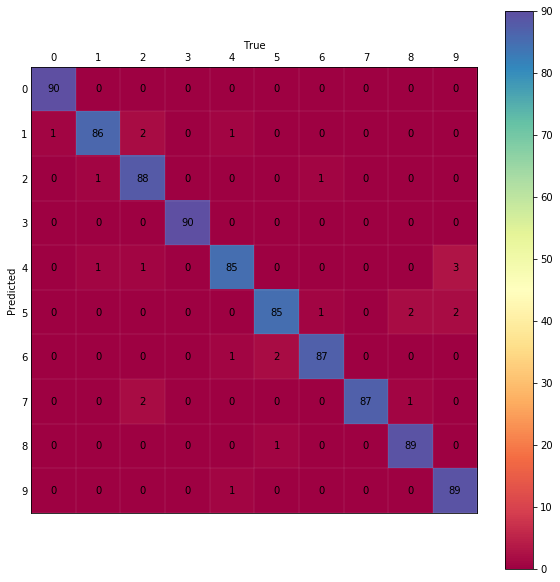

In [160]:
from utils.evaluation import get_confusion_matrix
# Confusion Matrix
confmat = get_confusion_matrix(Y_valid, Y_predicted_valid, plot=True)

#### Plot Test Set Confusion Matrix

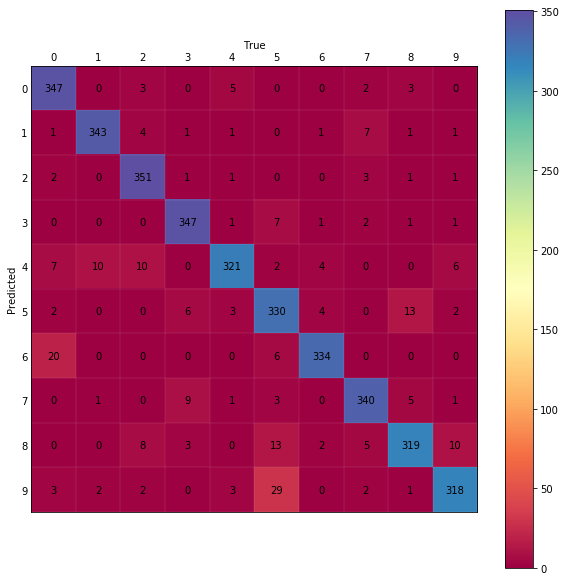

In [161]:
from utils.evaluation import get_confusion_matrix
# Confusion Matrix
confmat = get_confusion_matrix(Y_test, Y_predicted_test, plot=True)

# Backup Code
-----

In [11]:
from keras.models import load_model
mymodel.model = load_model("checkpoints/1523369406.7123575/naive_overfit_gru-30-0.97.hdf5")